In [80]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Reading Files

In [2]:
numerical = pd.read_csv('files_for_lab/numerical.csv')
categorical = pd.read_csv('files_for_lab/categorical.csv')
targets = pd.read_csv('files_for_lab/target.csv')

In [3]:
#concate the whole data
data = pd.concat([numerical, categorical, targets], axis = 1)

In [4]:
# see there is any N/A or Not
sum(data.isna().sum())

0

In [5]:
data.shape

(95412, 339)

In [14]:
data['TARGET_B'].apply(lambda x:str(x)).shape

(95412,)

# Change Categorical to Numerical

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

y = data['TARGET_B'].apply(lambda x:str(x))
#y = [str(y) for y in y]
X = data.drop(['TARGET_B','TARGET_D'], axis = 1)

numericalX = X.select_dtypes(np.number)
categoricalX = X.select_dtypes('object')

display(categoricalX.head())


for col in categoricalX.columns:
    print(col, categoricalX[col].nunique())
print()

encoder = OneHotEncoder(drop='first').fit(categoricalX)
encoded_categorical = encoder.transform(categoricalX).toarray()
encoded_categorical_df = pd.DataFrame(encoded_categorical, 
                                   columns=encoder.get_feature_names_out(),
                                   index=categoricalX.index)

X = pd.concat([numericalX, encoded_categorical_df], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

,STATE,HOMEOWNR,GENDER,RFA_2R,RFA_2A,GEOCODE2,DOMAIN_A
0,IL,H,F,L,E,C,T
1,CA,H,M,L,G,A,S
2,NC,U,M,L,E,C,R
3,CA,U,F,L,E,C,R
4,FL,H,F,L,F,A,S


STATE 12
HOMEOWNR 2
GENDER 3
RFA_2R 1
RFA_2A 4
GEOCODE2 4
DOMAIN_A 5



# Upsampling

In [28]:
# We have Class imbalnce
data['TARGET_B'].value_counts()

0    90569
1     4843
Name: TARGET_B, dtype: int64

In [29]:
X_train.head()

,TCODE,AGE,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,...,RFA_2A_E,RFA_2A_F,RFA_2A_G,GEOCODE2_B,GEOCODE2_C,GEOCODE2_D,DOMAIN_A_R,DOMAIN_A_S,DOMAIN_A_T,DOMAIN_A_U
79401,1,75.0,4,6,2,0,31,10,68,6,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
86429,0,53.0,5,9,0,0,29,24,38,7,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
76729,1,60.0,5,1,5,0,42,16,62,10,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38838,1,77.0,6,6,9,1,40,23,41,8,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
83012,3,55.0,5,2,21,33,27,29,18,12,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [49]:
# for Upsampling we need to temporarily concat X_train and y_train
trainset = pd.concat([X_train, y_train], axis=1)

# Manual way to Upsampling category 0:
category_0 = trainset[trainset['TARGET_B']=='0']
print(category_0.shape)

category_1 = trainset[trainset['TARGET_B']== '1' ]
print(category_1.shape)
#72486/4843= 18.8 almost 15 so we need to copy 19 times the category 1 to have same amount of 0
#category_up_1 = pd.concat([category_1,category_1,category_1,category_1,category_1,
#                           category_1,category_1,category_1,category_1,category_1,
#                           category_1,category_1,category_1,category_1,category_1,
#                           category_1,category_1,category_1,category_1])
#print(category_up_1.shape)
# make cat0 and 1 to have same shape
category_up_1=category_1.sample(len(trainset[trainset['TARGET_B']=='0']),replace=True)
print(category_up_1.shape)

(72486, 355)
(3843, 355)
(72486, 355)


In [50]:
#concatinate
trainset_new = pd.concat([category_0, category_up_1], axis = 0)
trainset_new = trainset_new.sample(frac =1) #randomize the rows
X_train = trainset_new.drop(['TARGET_B'], axis=1)
y_train = trainset_new['TARGET_B']
#data = data.reset_index(drop=True)
print(X_train.shape)

(144972, 354)


In [ ]:
X_train = pd.DataFrame(X_train)
X_test = pd.DataFrame(X_test)


y_train_regression = X_train['TARGET_D']
y_test_regression = X_test['TARGET_D']

# Now we can remove the column target d from the set of features
X_train = X_train.drop(['TARGET_D'], axis = 1)
X_test = X_test.drop(['TARGET_D'], axis = 1)

# Random Forest

In [73]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

clf = RandomForestClassifier(max_depth=5,
                             min_samples_split=20,
                             min_samples_leaf =20,
                             max_samples=0.8,
                             random_state = 42)
clf.fit(X_train, y_train)

print("The accuracy for the Random Forest in the TRAIN set is {:.2f}".format(clf.score(X_train, y_train)))
print("The accuracy for the Random Forest in the TEST  set is {:.2f}".format(clf.score(X_test, y_test)))

y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred))
conf_m=confusion_matrix(y_test, y_pred)

The accuracy for the Random Forest in the TRAIN set is 0.62
The accuracy for the Random Forest in the TEST  set is 0.60


0    18083
1     1000
Name: TARGET_B, dtype: int64

array([[10863,  7220],
       [  443,   557]])

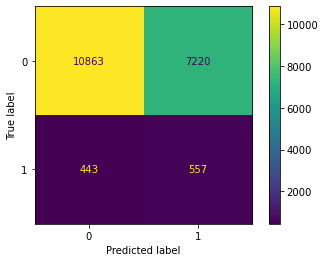

In [81]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, ConfusionMatrixDisplay

cm_train = confusion_matrix(y_test,y_pred)
cm_train
disp = ConfusionMatrixDisplay(cm_train,display_labels=clf.classes_);
disp.plot()
plt.show()

In [ ]:
# so here for us true positive which in this case would be predicting 1 (yes to donate) so for us recall is more important

In [60]:
from sklearn.metrics import recall_score, make_scorer
recall= make_scorer(recall_score)
print("The Recall for the Random Forest in the Train set is  "+ str(round(recall_score(y_train, y_pred_train,pos_label='1'),2)))
print("The Recall for the Random Forest in the TEST set is  "+ str(round(recall_score(y_test, y_pred,pos_label='1'),2)))

The Recall for the Random Forest in the Train set is  0.64
The Recall for the Random Forest in the TEST set is  0.56


# Modifying our model

In [ ]:
#3*3*2*2*5 model.score() Accuracy, recall_score()

In [61]:
from sklearn.model_selection import GridSearchCV

grid = {
    'n_estimators': [50, 100, 150], 
    'min_samples_split': [30,40,50], 
    'min_samples_leaf' : [1, 2],
    'max_depth':[10,20]
    }
model = RandomForestClassifier()
grid_search = GridSearchCV(estimator = model, param_grid = grid, cv = 5,scoring=recall, verbose=10) 
grid_search.fit(X_train,y_train)
grid_search.best_params_ #To check the best set of parameters returned

Fitting 5 folds for each of 36 candidates, totalling 180 fits
[CV 1/5; 1/36] START max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 1/36] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=50;, score=nan total time=  48.5s
[CV 2/5; 1/36] START max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 1/36] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=50;, score=nan total time=  46.4s
[CV 3/5; 1/36] START max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 1/36] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=50;, score=nan total time=  45.9s
[CV 4/5; 1/36] START max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 1/36] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=50;, score=nan total time=  37.8s
[CV 5/5; 1/36] START max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 1/36] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=50;, score=nan total time=  51.6s
[CV 1/5; 2/36] START max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 2/36] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=100;, score=nan total time= 1.5min
[CV 2/5; 2/36] START max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 2/36] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=100;, score=nan total time= 1.5min
[CV 3/5; 2/36] START max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 2/36] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=100;, score=nan total time= 1.4min
[CV 4/5; 2/36] START max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 2/36] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=100;, score=nan total time= 2.7min
[CV 5/5; 2/36] START max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 2/36] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=100;, score=nan total time= 1.3min
[CV 1/5; 3/36] START max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 3/36] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=150;, score=nan total time= 1.8min
[CV 2/5; 3/36] START max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 3/36] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=150;, score=nan total time= 1.8min
[CV 3/5; 3/36] START max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 3/36] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=150;, score=nan total time= 1.9min
[CV 4/5; 3/36] START max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 3/36] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=150;, score=nan total time= 1.8min
[CV 5/5; 3/36] START max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 3/36] END max_depth=10, min_samples_leaf=1, min_samples_split=30, n_estimators=150;, score=nan total time= 2.1min
[CV 1/5; 4/36] START max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 4/36] END max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=50;, score=nan total time=  43.1s
[CV 2/5; 4/36] START max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 4/36] END max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=50;, score=nan total time=  44.1s
[CV 3/5; 4/36] START max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 4/36] END max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=50;, score=nan total time=  37.8s
[CV 4/5; 4/36] START max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 4/36] END max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=50;, score=nan total time=  40.4s
[CV 5/5; 4/36] START max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 4/36] END max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=50;, score=nan total time=  37.0s
[CV 1/5; 5/36] START max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 5/36] END max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=100;, score=nan total time= 1.2min
[CV 2/5; 5/36] START max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 5/36] END max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=100;, score=nan total time= 1.3min
[CV 3/5; 5/36] START max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 5/36] END max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=100;, score=nan total time= 1.2min
[CV 4/5; 5/36] START max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 5/36] END max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=100;, score=nan total time= 1.9min
[CV 5/5; 5/36] START max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 5/36] END max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=100;, score=nan total time= 2.2min
[CV 1/5; 6/36] START max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 6/36] END max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=150;, score=nan total time= 3.9min
[CV 2/5; 6/36] START max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 6/36] END max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=150;, score=nan total time= 5.2min
[CV 3/5; 6/36] START max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 6/36] END max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=150;, score=nan total time= 2.8min
[CV 4/5; 6/36] START max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 6/36] END max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=150;, score=nan total time= 2.1min
[CV 5/5; 6/36] START max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 6/36] END max_depth=10, min_samples_leaf=1, min_samples_split=40, n_estimators=150;, score=nan total time= 1.9min
[CV 1/5; 7/36] START max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 7/36] END max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=50;, score=nan total time=  37.8s
[CV 2/5; 7/36] START max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 7/36] END max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=50;, score=nan total time=  38.0s
[CV 3/5; 7/36] START max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 7/36] END max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=50;, score=nan total time=  34.8s
[CV 4/5; 7/36] START max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 7/36] END max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=50;, score=nan total time=  37.0s
[CV 5/5; 7/36] START max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 7/36] END max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=50;, score=nan total time=  36.1s
[CV 1/5; 8/36] START max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 8/36] END max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=100;, score=nan total time= 1.2min
[CV 2/5; 8/36] START max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 8/36] END max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=100;, score=nan total time= 1.1min
[CV 3/5; 8/36] START max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 8/36] END max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=100;, score=nan total time= 1.2min
[CV 4/5; 8/36] START max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 8/36] END max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=100;, score=nan total time= 1.2min
[CV 5/5; 8/36] START max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 8/36] END max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=100;, score=nan total time= 1.1min
[CV 1/5; 9/36] START max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 9/36] END max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=150;, score=nan total time= 2.5min
[CV 2/5; 9/36] START max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 9/36] END max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=150;, score=nan total time= 3.8min
[CV 3/5; 9/36] START max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 9/36] END max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=150;, score=nan total time= 2.0min
[CV 4/5; 9/36] START max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 9/36] END max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=150;, score=nan total time= 1.7min
[CV 5/5; 9/36] START max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 9/36] END max_depth=10, min_samples_leaf=1, min_samples_split=50, n_estimators=150;, score=nan total time= 1.7min
[CV 1/5; 10/36] START max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 10/36] END max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=50;, score=nan total time=  36.5s
[CV 2/5; 10/36] START max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 10/36] END max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=50;, score=nan total time=  35.1s
[CV 3/5; 10/36] START max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 10/36] END max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=50;, score=nan total time=  36.1s
[CV 4/5; 10/36] START max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 10/36] END max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=50;, score=nan total time=  35.9s
[CV 5/5; 10/36] START max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 10/36] END max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=50;, score=nan total time=  36.1s
[CV 1/5; 11/36] START max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 11/36] END max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=100;, score=nan total time= 1.1min
[CV 2/5; 11/36] START max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 11/36] END max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=100;, score=nan total time= 1.2min
[CV 3/5; 11/36] START max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 11/36] END max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=100;, score=nan total time= 1.1min
[CV 4/5; 11/36] START max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 11/36] END max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=100;, score=nan total time= 1.2min
[CV 5/5; 11/36] START max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 11/36] END max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=100;, score=nan total time= 1.2min
[CV 1/5; 12/36] START max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 12/36] END max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=150;, score=nan total time= 1.7min
[CV 2/5; 12/36] START max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 12/36] END max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=150;, score=nan total time= 1.7min
[CV 3/5; 12/36] START max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 12/36] END max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=150;, score=nan total time= 1.8min
[CV 4/5; 12/36] START max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 12/36] END max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=150;, score=nan total time= 2.0min
[CV 5/5; 12/36] START max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 12/36] END max_depth=10, min_samples_leaf=2, min_samples_split=30, n_estimators=150;, score=nan total time= 1.5min
[CV 1/5; 13/36] START max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 13/36] END max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=50;, score=nan total time=  28.4s
[CV 2/5; 13/36] START max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 13/36] END max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=50;, score=nan total time=  28.2s
[CV 3/5; 13/36] START max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 13/36] END max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=50;, score=nan total time=  28.1s
[CV 4/5; 13/36] START max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 13/36] END max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=50;, score=nan total time=  27.9s
[CV 5/5; 13/36] START max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 13/36] END max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=50;, score=nan total time=  27.9s
[CV 1/5; 14/36] START max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 14/36] END max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=100;, score=nan total time=  54.2s
[CV 2/5; 14/36] START max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 14/36] END max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=100;, score=nan total time=  54.1s
[CV 3/5; 14/36] START max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 14/36] END max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=100;, score=nan total time=  55.7s
[CV 4/5; 14/36] START max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 14/36] END max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=100;, score=nan total time=  57.9s
[CV 5/5; 14/36] START max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 14/36] END max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=100;, score=nan total time=  54.1s
[CV 1/5; 15/36] START max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 15/36] END max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=150;, score=nan total time= 1.3min
[CV 2/5; 15/36] START max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 15/36] END max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=150;, score=nan total time= 1.3min
[CV 3/5; 15/36] START max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 15/36] END max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=150;, score=nan total time=11.2min
[CV 4/5; 15/36] START max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 15/36] END max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=150;, score=nan total time= 1.6min
[CV 5/5; 15/36] START max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 15/36] END max_depth=10, min_samples_leaf=2, min_samples_split=40, n_estimators=150;, score=nan total time= 1.3min
[CV 1/5; 16/36] START max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 16/36] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=50;, score=nan total time=  27.3s
[CV 2/5; 16/36] START max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 16/36] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=50;, score=nan total time=  26.9s
[CV 3/5; 16/36] START max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 16/36] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=50;, score=nan total time=  27.6s
[CV 4/5; 16/36] START max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 16/36] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=50;, score=nan total time=  27.3s
[CV 5/5; 16/36] START max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 16/36] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=50;, score=nan total time=  27.1s
[CV 1/5; 17/36] START max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 17/36] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=100;, score=nan total time=  52.5s
[CV 2/5; 17/36] START max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 17/36] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=100;, score=nan total time=  52.2s
[CV 3/5; 17/36] START max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 17/36] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=100;, score=nan total time=  51.9s
[CV 4/5; 17/36] START max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 17/36] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=100;, score=nan total time=  52.4s
[CV 5/5; 17/36] START max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 17/36] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=100;, score=nan total time=  52.6s
[CV 1/5; 18/36] START max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 18/36] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=150;, score=nan total time= 1.3min
[CV 2/5; 18/36] START max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 18/36] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=150;, score=nan total time= 1.3min
[CV 3/5; 18/36] START max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 18/36] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=150;, score=nan total time= 1.3min
[CV 4/5; 18/36] START max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 18/36] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=150;, score=nan total time= 1.3min
[CV 5/5; 18/36] START max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 18/36] END max_depth=10, min_samples_leaf=2, min_samples_split=50, n_estimators=150;, score=nan total time= 1.3min
[CV 1/5; 19/36] START max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 19/36] END max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=50;, score=nan total time=  45.0s
[CV 2/5; 19/36] START max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 19/36] END max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=50;, score=nan total time=  44.5s
[CV 3/5; 19/36] START max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 19/36] END max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=50;, score=nan total time=  44.7s
[CV 4/5; 19/36] START max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 19/36] END max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=50;, score=nan total time=  43.6s
[CV 5/5; 19/36] START max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 19/36] END max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=50;, score=nan total time=  45.1s
[CV 1/5; 20/36] START max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 20/36] END max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=100;, score=nan total time= 1.5min
[CV 2/5; 20/36] START max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 20/36] END max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=100;, score=nan total time= 1.5min
[CV 3/5; 20/36] START max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 20/36] END max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=100;, score=nan total time= 1.5min
[CV 4/5; 20/36] START max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 20/36] END max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=100;, score=nan total time= 1.5min
[CV 5/5; 20/36] START max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 20/36] END max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=100;, score=nan total time= 1.5min
[CV 1/5; 21/36] START max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 21/36] END max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=150;, score=nan total time= 2.2min
[CV 2/5; 21/36] START max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 21/36] END max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=150;, score=nan total time= 2.2min
[CV 3/5; 21/36] START max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 21/36] END max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=150;, score=nan total time= 2.2min
[CV 4/5; 21/36] START max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 21/36] END max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=150;, score=nan total time= 2.2min
[CV 5/5; 21/36] START max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 21/36] END max_depth=20, min_samples_leaf=1, min_samples_split=30, n_estimators=150;, score=nan total time= 2.2min
[CV 1/5; 22/36] START max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 22/36] END max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=50;, score=nan total time=  44.2s
[CV 2/5; 22/36] START max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 22/36] END max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=50;, score=nan total time=  44.3s
[CV 3/5; 22/36] START max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 22/36] END max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=50;, score=nan total time=  44.1s
[CV 4/5; 22/36] START max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 22/36] END max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=50;, score=nan total time=  43.9s
[CV 5/5; 22/36] START max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 22/36] END max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=50;, score=nan total time=  43.9s
[CV 1/5; 23/36] START max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 23/36] END max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=100;, score=nan total time= 1.4min
[CV 2/5; 23/36] START max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 23/36] END max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=100;, score=nan total time= 1.5min
[CV 3/5; 23/36] START max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 23/36] END max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=100;, score=nan total time= 1.5min
[CV 4/5; 23/36] START max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 23/36] END max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=100;, score=nan total time= 1.5min
[CV 5/5; 23/36] START max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 23/36] END max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=100;, score=nan total time= 1.5min
[CV 1/5; 24/36] START max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 24/36] END max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=150;, score=nan total time= 2.2min
[CV 2/5; 24/36] START max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 24/36] END max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=150;, score=nan total time= 2.2min
[CV 3/5; 24/36] START max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 24/36] END max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=150;, score=nan total time= 2.3min
[CV 4/5; 24/36] START max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 24/36] END max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=150;, score=nan total time= 2.2min
[CV 5/5; 24/36] START max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 24/36] END max_depth=20, min_samples_leaf=1, min_samples_split=40, n_estimators=150;, score=nan total time= 2.2min
[CV 1/5; 25/36] START max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 25/36] END max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=50;, score=nan total time=  45.4s
[CV 2/5; 25/36] START max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 25/36] END max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=50;, score=nan total time=  46.0s
[CV 3/5; 25/36] START max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 25/36] END max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=50;, score=nan total time=  45.3s
[CV 4/5; 25/36] START max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 25/36] END max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=50;, score=nan total time=  44.5s
[CV 5/5; 25/36] START max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 25/36] END max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=50;, score=nan total time=  45.2s
[CV 1/5; 26/36] START max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 26/36] END max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=100;, score=nan total time= 1.5min
[CV 2/5; 26/36] START max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 26/36] END max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=100;, score=nan total time= 1.5min
[CV 3/5; 26/36] START max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 26/36] END max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=100;, score=nan total time= 1.5min
[CV 4/5; 26/36] START max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 26/36] END max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=100;, score=nan total time= 1.5min
[CV 5/5; 26/36] START max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 26/36] END max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=100;, score=nan total time= 1.5min
[CV 1/5; 27/36] START max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 27/36] END max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=150;, score=nan total time= 2.2min
[CV 2/5; 27/36] START max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 27/36] END max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=150;, score=nan total time= 2.2min
[CV 3/5; 27/36] START max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 27/36] END max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=150;, score=nan total time= 2.2min
[CV 4/5; 27/36] START max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 27/36] END max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=150;, score=nan total time= 2.3min
[CV 5/5; 27/36] START max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 27/36] END max_depth=20, min_samples_leaf=1, min_samples_split=50, n_estimators=150;, score=nan total time= 2.2min
[CV 1/5; 28/36] START max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 28/36] END max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=50;, score=nan total time=  45.6s
[CV 2/5; 28/36] START max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 28/36] END max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=50;, score=nan total time=  45.8s
[CV 3/5; 28/36] START max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 28/36] END max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=50;, score=nan total time=  46.3s
[CV 4/5; 28/36] START max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 28/36] END max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=50;, score=nan total time=  45.3s
[CV 5/5; 28/36] START max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 28/36] END max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=50;, score=nan total time=  45.6s
[CV 1/5; 29/36] START max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 29/36] END max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=100;, score=nan total time= 1.5min
[CV 2/5; 29/36] START max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 29/36] END max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=100;, score=nan total time= 1.5min
[CV 3/5; 29/36] START max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 29/36] END max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=100;, score=nan total time= 1.5min
[CV 4/5; 29/36] START max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 29/36] END max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=100;, score=nan total time= 1.5min
[CV 5/5; 29/36] START max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 29/36] END max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=100;, score=nan total time= 1.5min
[CV 1/5; 30/36] START max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 30/36] END max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=150;, score=nan total time= 2.3min
[CV 2/5; 30/36] START max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 30/36] END max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=150;, score=nan total time= 2.2min
[CV 3/5; 30/36] START max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 30/36] END max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=150;, score=nan total time= 2.2min
[CV 4/5; 30/36] START max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 30/36] END max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=150;, score=nan total time= 2.2min
[CV 5/5; 30/36] START max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 30/36] END max_depth=20, min_samples_leaf=2, min_samples_split=30, n_estimators=150;, score=nan total time= 2.2min
[CV 1/5; 31/36] START max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 31/36] END max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=50;, score=nan total time=  45.5s
[CV 2/5; 31/36] START max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 31/36] END max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=50;, score=nan total time=  45.7s
[CV 3/5; 31/36] START max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 31/36] END max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=50;, score=nan total time=  45.4s
[CV 4/5; 31/36] START max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 31/36] END max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=50;, score=nan total time=  45.0s
[CV 5/5; 31/36] START max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 31/36] END max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=50;, score=nan total time=  45.0s
[CV 1/5; 32/36] START max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 32/36] END max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=100;, score=nan total time= 1.5min
[CV 2/5; 32/36] START max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 32/36] END max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=100;, score=nan total time= 1.5min
[CV 3/5; 32/36] START max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 32/36] END max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=100;, score=nan total time= 1.5min
[CV 4/5; 32/36] START max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 32/36] END max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=100;, score=nan total time= 1.5min
[CV 5/5; 32/36] START max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 32/36] END max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=100;, score=nan total time= 1.5min
[CV 1/5; 33/36] START max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 33/36] END max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=150;, score=nan total time= 2.2min
[CV 2/5; 33/36] START max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 33/36] END max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=150;, score=nan total time= 2.2min
[CV 3/5; 33/36] START max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 33/36] END max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=150;, score=nan total time= 2.2min
[CV 4/5; 33/36] START max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 33/36] END max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=150;, score=nan total time= 2.3min
[CV 5/5; 33/36] START max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 33/36] END max_depth=20, min_samples_leaf=2, min_samples_split=40, n_estimators=150;, score=nan total time= 2.2min
[CV 1/5; 34/36] START max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 34/36] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=50;, score=nan total time=  45.2s
[CV 2/5; 34/36] START max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 34/36] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=50;, score=nan total time=  44.8s
[CV 3/5; 34/36] START max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 34/36] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=50;, score=nan total time=  47.3s
[CV 4/5; 34/36] START max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 34/36] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=50;, score=nan total time=  53.7s
[CV 5/5; 34/36] START max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=50


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 34/36] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=50;, score=nan total time=  44.9s
[CV 1/5; 35/36] START max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 35/36] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=100;, score=nan total time= 1.5min
[CV 2/5; 35/36] START max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 35/36] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=100;, score=nan total time= 1.5min
[CV 3/5; 35/36] START max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 35/36] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=100;, score=nan total time= 1.5min
[CV 4/5; 35/36] START max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 35/36] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=100;, score=nan total time= 1.5min
[CV 5/5; 35/36] START max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=100


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 35/36] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=100;, score=nan total time= 1.5min
[CV 1/5; 36/36] START max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 1/5; 36/36] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=150;, score=nan total time= 2.2min
[CV 2/5; 36/36] START max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 2/5; 36/36] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=150;, score=nan total time= 2.2min
[CV 3/5; 36/36] START max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 3/5; 36/36] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=150;, score=nan total time= 2.2min
[CV 4/5; 36/36] START max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 4/5; 36/36] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=150;, score=nan total time= 2.3min
[CV 5/5; 36/36] START max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=150


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

[CV 5/5; 36/36] END max_depth=20, min_samples_leaf=2, min_samples_split=50, n_estimators=150;, score=nan total time= 2.2min


{'max_depth': 10,
 'min_samples_leaf': 1,
 'min_samples_split': 30,
 'n_estimators': 50}

In [87]:
clf = RandomForestClassifier(max_depth=10,
                             min_samples_split=30,
                             min_samples_leaf =1,
                             n_estimators= 50,
                             )
clf.fit(X_train, y_train)

print("The accuracy for the Random Forest in the TRAIN set is {:.2f}".format(clf.score(X_train, y_train)))
print("The accuracy for the Random Forest in the TEST  set is {:.2f}".format(clf.score(X_test, y_test)))

y_pred = clf.predict(X_test)
y_pred_train = clf.predict(X_train)
display(y_test.value_counts())
display(confusion_matrix(y_test, y_pred))
conf_m=confusion_matrix(y_test, y_pred)

The accuracy for the Random Forest in the TRAIN set is 0.84
The accuracy for the Random Forest in the TEST  set is 0.75


0    18083
1     1000
Name: TARGET_B, dtype: int64

array([[14062,  4021],
       [  657,   343]])

In [86]:
print("The Recall for the Random Forest in the Train set is  "+ str(round(recall_score(y_train, y_pred_train,pos_label='1'),2)))
print("The Recall for the Random Forest in the TEST set is  "+ str(round(recall_score(y_test, y_pred,pos_label='1'),2)))

The Recall for the Random Forest in the Train set is  0.89
The Recall for the Random Forest in the TEST set is  0.33


In [89]:
param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

In [97]:
def grid_search_wrapper(refit_score='recall_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    grid_search = GridSearchCV(clf, param_grid, scoring=recall, refit=refit_score,
                           cv=5, return_train_score=True, n_jobs=-1)
    grid_search.fit(X_train.values, y_train.values)

In [96]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')


/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:776: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 219, in __call__
    return self._score(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_scorer.py", line 267, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py", line 1913, in recall_score
    _, r, _, _ = precision_recall_fscore_support(
  File "/Users/mojgun/opt/anaconda3/lib/python3.9/site-packages/sklearn

KeyboardInterrupt: 